In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model

import numpy as np
import pandas as pd
import os

import random
from collections import deque
import matplotlib.pylab as plt

from sklearn.decomposition import PCA

Using TensorFlow backend.


# Imports of classes

In [2]:
from environment import ETFEnvironment, CryptoEnvironment
from agent import MinVarianceAgent, MaxSharpeAgent, MaxDecorrelationAgent, MaxReturnsAgent
from utils import *

In [3]:
N_ASSETS = 15 # 53
WINDOW_FIT = 180 # 252
WINDOW_HOLD = 90 # 252
env = CryptoEnvironment() # ETFEnvironment

In [4]:
agent_max_returns = MaxReturnsAgent(N_ASSETS, allow_short=True)
agent_minvar = MinVarianceAgent(N_ASSETS, allow_short=True)
agent_maxsharpe = MaxSharpeAgent(N_ASSETS, allow_short=True)
agent_maxdecorr = MaxDecorrelationAgent(N_ASSETS, allow_short=True)

# Reweighting process: optimization

In [5]:
actions_equal, actions_returns, actions_minvar, actions_maxsharpe, actions_maxdecorr = [], [], [], [], []
result_equal, result_returns, result_minvar, result_maxsharpe, result_maxdecorr = [], [], [], [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False)
    
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_minvar = agent_minvar.act(state)
    action_max_returns = agent_max_returns.act(state)
    action_maxsharpe = agent_maxsharpe.act(state)
    action_maxdecorr = agent_maxdecorr.act(state)
 
    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_minvar)
    result_minvar.append(r.tolist())
    actions_minvar.append(action_minvar)

    r = np.dot(state_action, action_max_returns)
    result_returns.append(r.tolist())
    actions_returns.append(action_max_returns)
    
    r = np.dot(state_action, action_maxsharpe)
    result_maxsharpe.append(r.tolist())
    actions_maxsharpe.append(action_maxsharpe)
    
    r = np.dot(state_action, action_maxdecorr)
    result_maxdecorr.append(r.tolist())
    actions_maxdecorr.append(action_maxdecorr)

# Evaluation

In [6]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_returns_vis = [item for sublist in result_returns for item in sublist]
result_minvar_vis = [item for sublist in result_minvar for item in sublist]
result_maxsharpe_vis = [item for sublist in result_maxsharpe for item in sublist]
result_maxdecorr_vis = [item for sublist in result_maxdecorr for item in sublist]

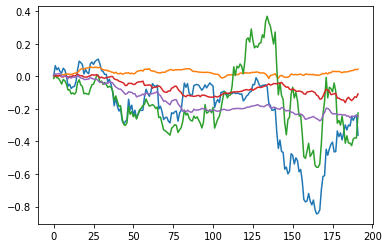

In [7]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum())
plt.plot(np.array(result_minvar_vis).cumsum())
plt.plot(np.array(result_returns_vis).cumsum())
plt.plot(np.array(result_maxsharpe_vis).cumsum())
plt.plot(np.array(result_maxdecorr_vis).cumsum())
plt.show()

In [8]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('MINVAR', print_stats(result_minvar_vis, result_equal_vis))
print('MAXRET', print_stats(result_returns_vis, result_equal_vis))
print('MAXSHRAPE', print_stats(result_maxsharpe_vis, result_equal_vis))
print('MAXDECORR', print_stats(result_maxdecorr_vis, result_equal_vis))

EQUAL [-0.0019, 0.0462, -0.6488, 0.0, 1.0]
MINVAR [0.0002, 0.0049, 0.7177, 0.0003, 0.0395]
MAXRET [-0.0012, 0.0567, -0.3097, 0.0, 0.6434]
MAXSHRAPE [-0.0006, 0.0079, -1.1852, -0.0006, -0.0091]
MAXDECORR [-0.0013, 0.0079, -2.6949, -0.0012, 0.0699]


# Visualization

In [9]:
import matplotlib
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')

In [10]:
def plot_results(benchmark_series, 
                 target_series, 
                 target_balances, 
                 n_assets = N_ASSETS,
                 columns = state.columns,
                 name2plot = '',
                 path2save = './',
                 base_name_series = 'series'):
    
#     N = len(np.array(benchmark_series).cumsum())
    N = len(np.array([item for sublist in benchmark_series for item in sublist]).cumsum()) 
    
    if not os.path.exists(path2save):
        os.makedirs(path2save)

    for i in range(0, len(target_balances)):

        current_range = np.arange(0, N)
        current_ts = np.zeros(N)
        current_ts2 = np.zeros(N)

        ts_benchmark = np.array([item for sublist in benchmark_series[:i+1] for item in sublist]).cumsum()
        ts_target = np.array([item for sublist in target_series[:i+1] for item in sublist]).cumsum()

        t = len(ts_benchmark)
        current_ts[:t] = ts_benchmark
        current_ts2[:t] = ts_target

        current_ts[current_ts == 0] = ts_benchmark[-1]
        current_ts2[current_ts2 == 0] = ts_target[-1]

        plt.figure(figsize = (12, 10))
        
        plt.subplot(2, 1, 1)
        plt.bar(np.arange(n_assets), target_balances[i], color = 'grey')
        plt.xticks(np.arange(n_assets), columns, rotation='vertical')

        plt.subplot(2, 1, 2)
        plt.colormaps = current_cmap
        plt.plot(current_range[:t], current_ts[:t], color = 'black', label = 'Benchmark')
        plt.plot(current_range[:t], current_ts2[:t], color = 'red', label = name2plot)
        plt.plot(current_range[t:], current_ts[t:], ls = '--', lw = .1, color = 'black')
        plt.autoscale(False)
        plt.ylim([-1, 1])
        plt.legend()
        plt.savefig(path2save + base_name_series + str(i) + '.jpg')

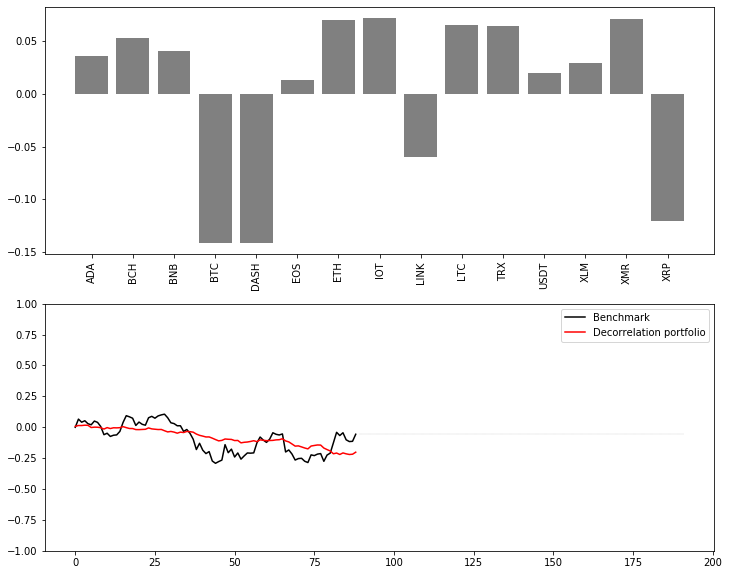

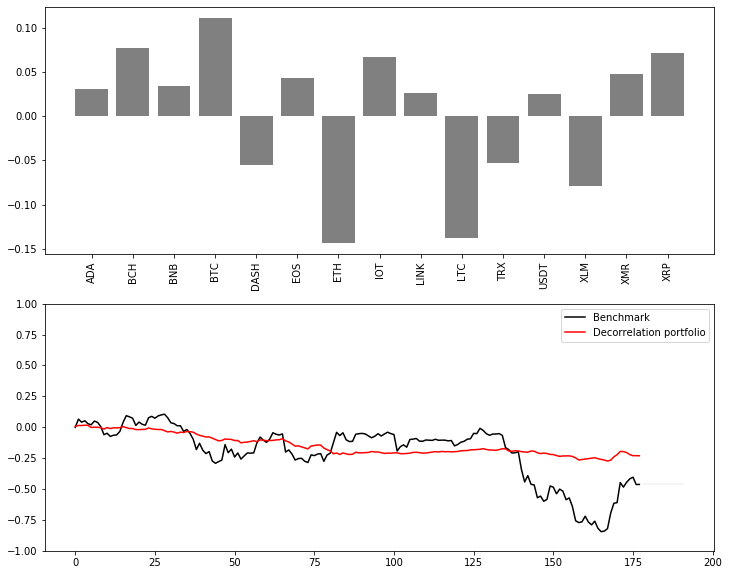

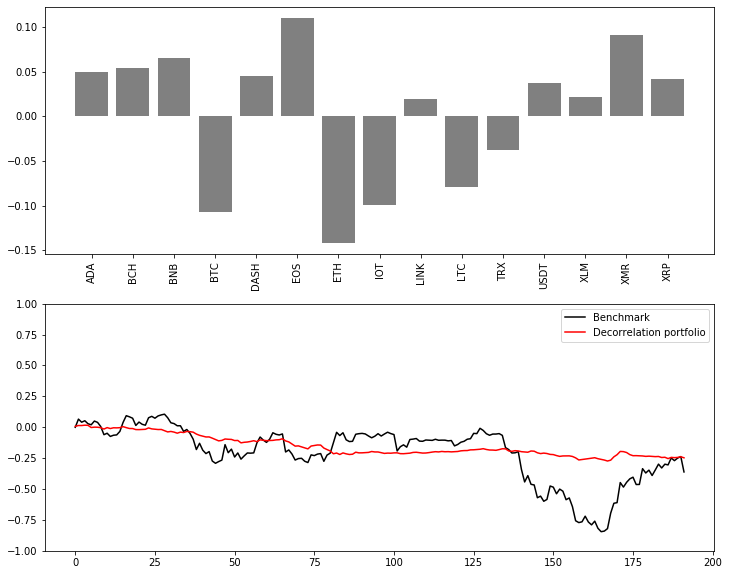

In [11]:
plot_results(result_equal, 
             result_maxdecorr, 
             actions_maxdecorr, 
             N_ASSETS,
             state.columns.tolist(), 
             'Decorrelation portfolio', './images/decorr/', 'series')

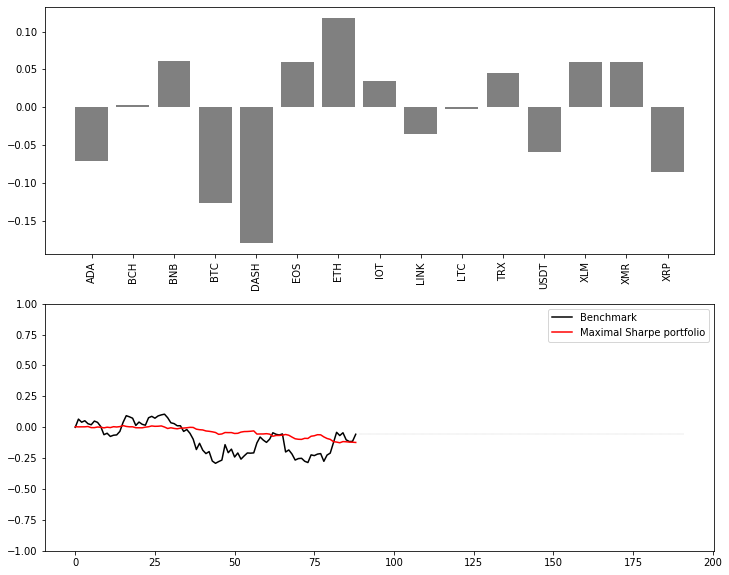

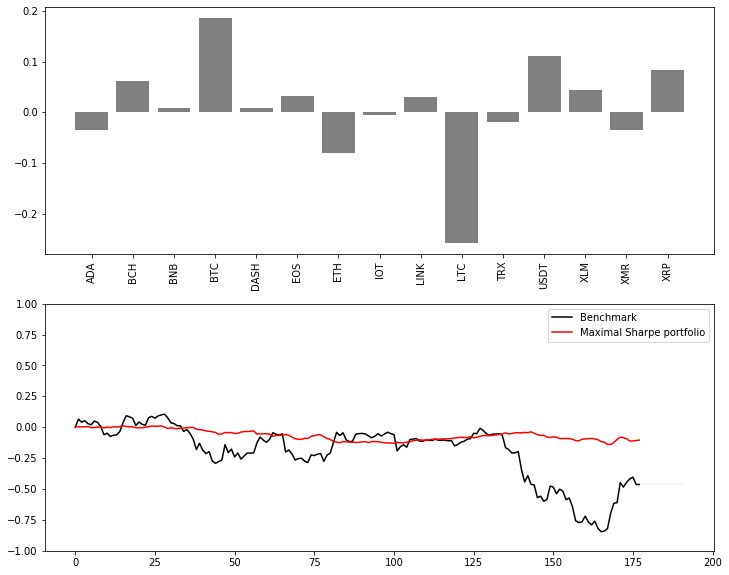

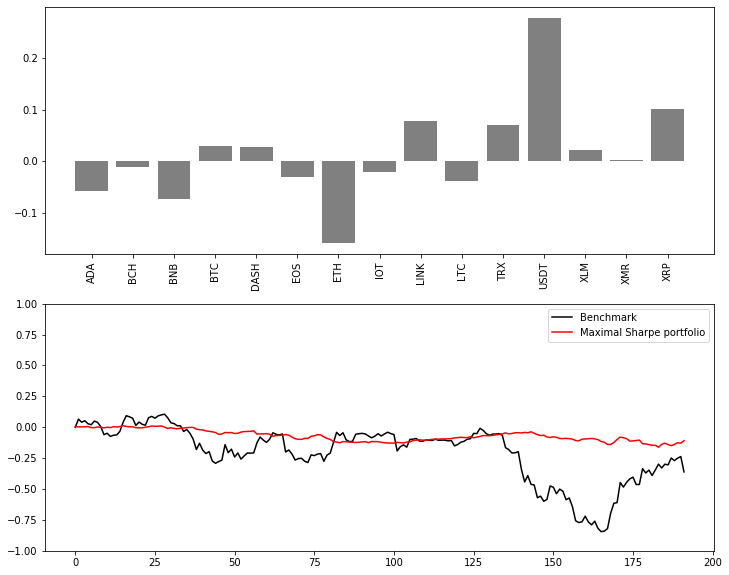

In [12]:
plot_results(result_equal, 
             result_maxsharpe, 
             actions_maxsharpe,  
             N_ASSETS,
             state.columns.tolist(), 
             'Maximal Sharpe portfolio', './images/sharpe/', 'series')

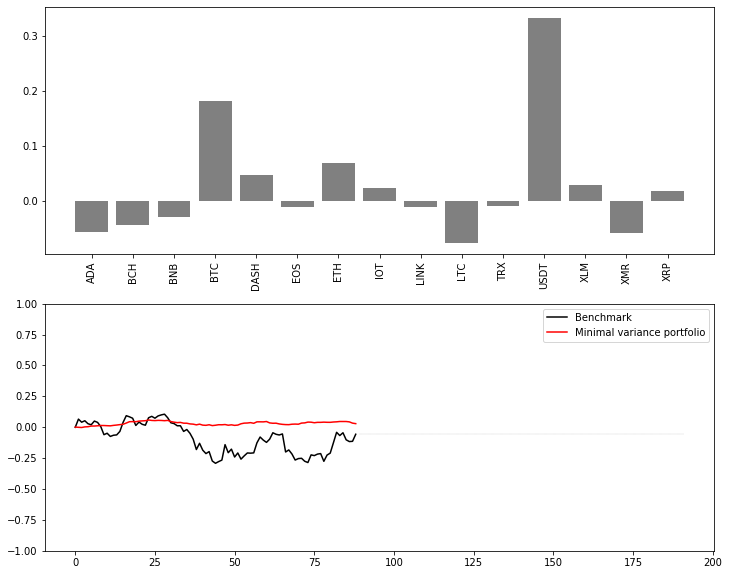

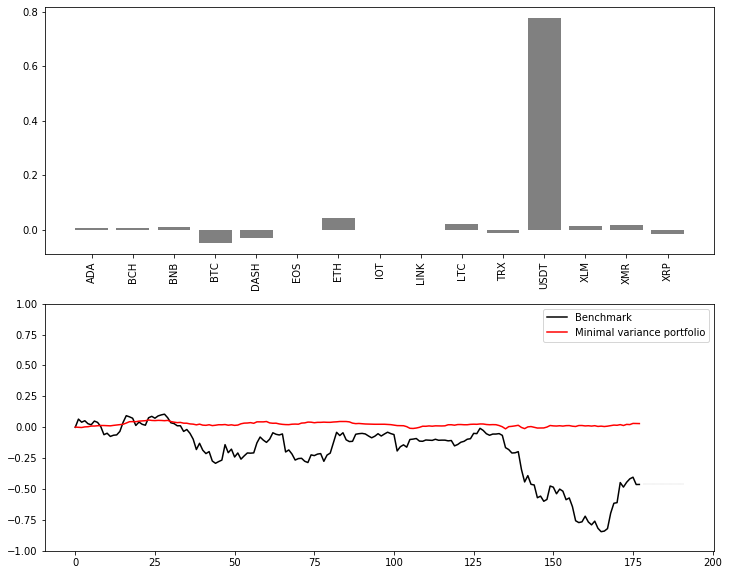

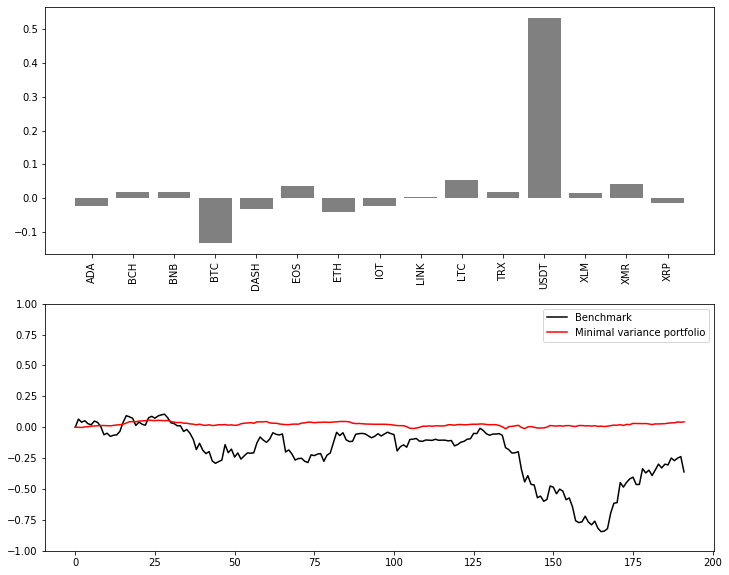

In [13]:
plot_results(result_equal, 
             result_minvar, 
             actions_minvar,  
             N_ASSETS,
             state.columns.tolist(), 
             'Minimal variance portfolio', './images/minvar/', 'series')

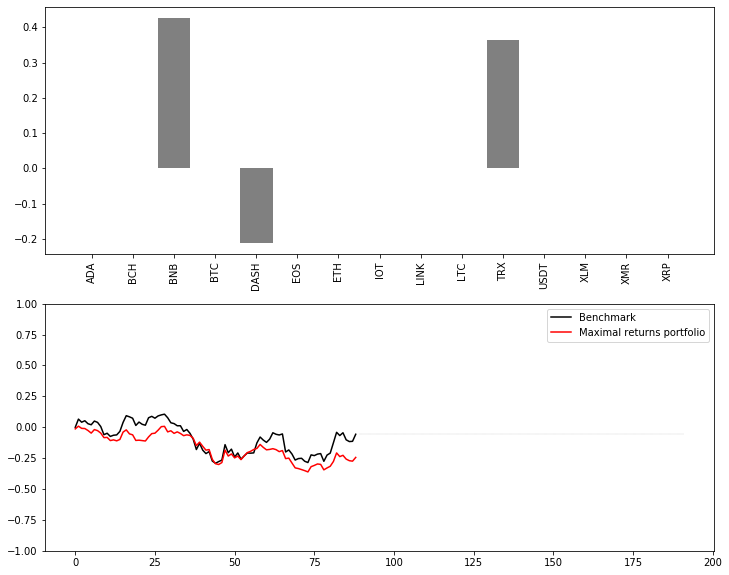

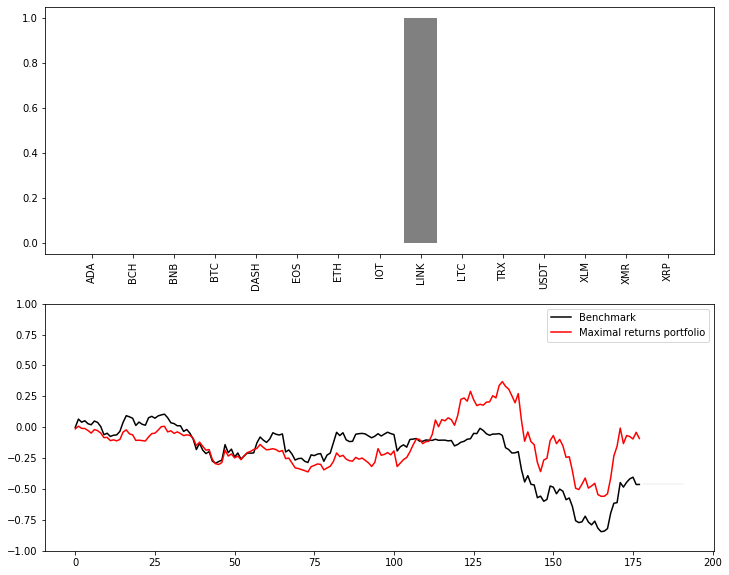

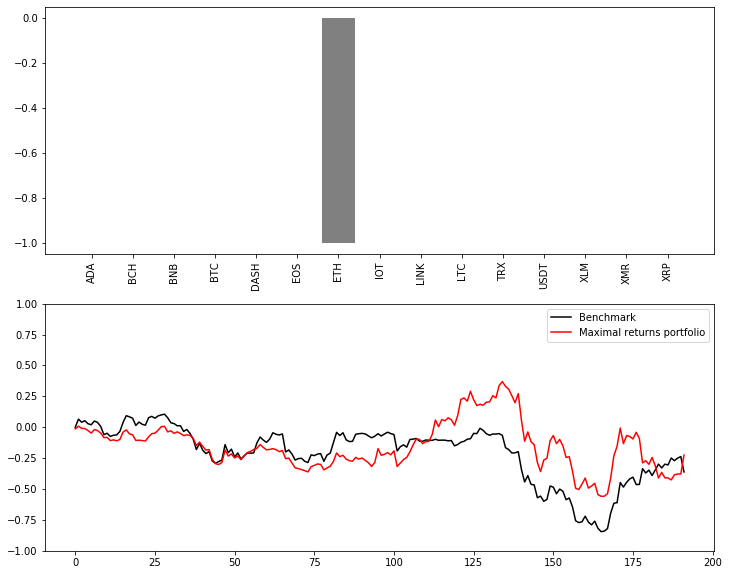

In [14]:
plot_results(result_equal, 
             result_returns, 
             actions_returns,  
             N_ASSETS,
             state.columns.tolist(), 
             'Maximal returns portfolio', './images/maxret/', 'series')

# Reweighting process: PCA

In [15]:
from agent import PCAAgent

In [50]:
agent_pca = PCAAgent(N_ASSETS, allow_short=True, pc_id=0)

In [51]:
actions_equal, actions_pca = [], []
result_equal, result_pca = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False)
    
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_pca = agent_pca.act(state)
 
    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_pca)
    result_pca.append(r.tolist())
    actions_pca.append(action_pca)

# Evaluation

In [52]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_pca_vis = [item for sublist in result_pca for item in sublist]

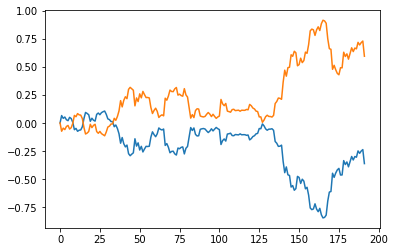

In [53]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum())
plt.plot(np.array(result_pca_vis).cumsum())
plt.show()

In [54]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('PCA', print_stats(result_pca_vis, result_equal_vis))

EQUAL [-0.0019, 0.0462, -0.6488, 0.0, 1.0]
PCA [0.0031, 0.0501, 0.9838, 0.0015, -0.8424]


# Visualization

In [21]:
import matplotlib
current_cmap = matplotlib.cm.get_cmap()

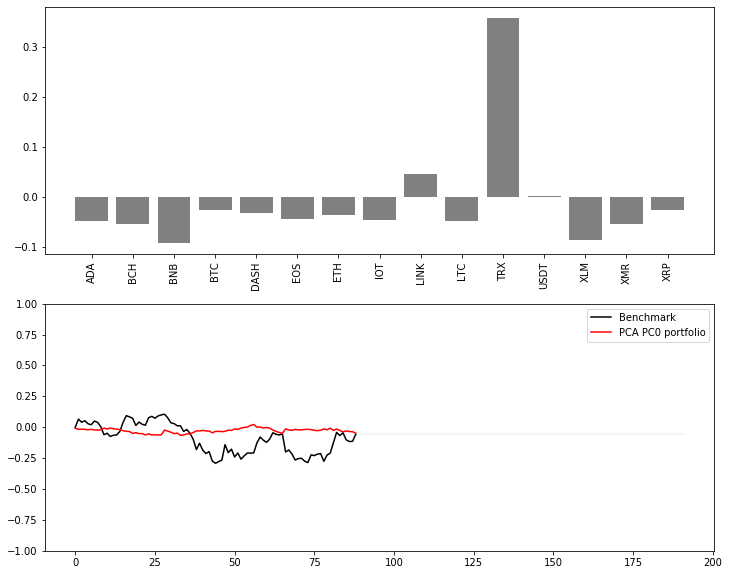

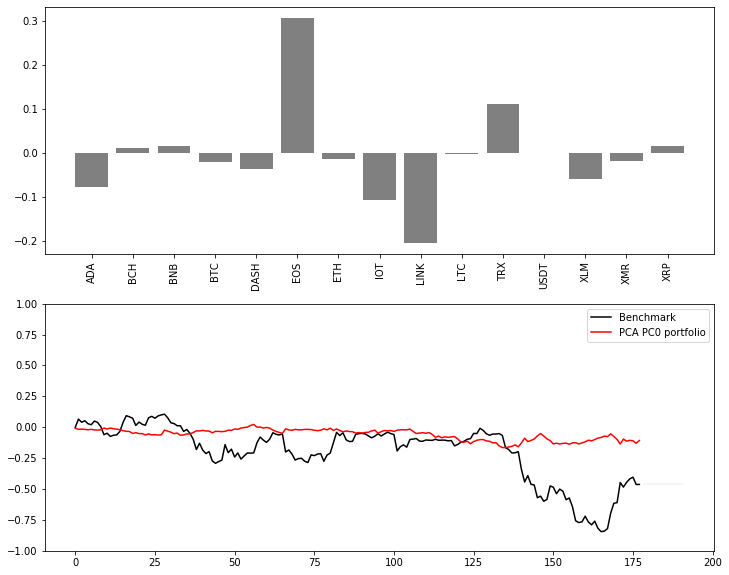

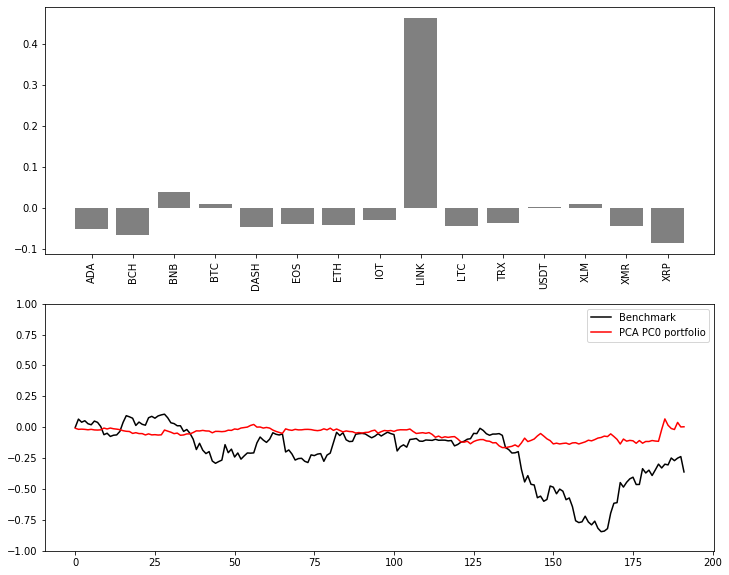

In [22]:
plot_results(result_equal, 
             result_pca, 
             actions_pca, 
             N_ASSETS,
             state.columns, 
             'PCA PC0 portfolio', './images/pca/', 'series')

# Reweighting process: HRP

In [23]:
from agent import HRPAgent

In [24]:
agent_hrp = HRPAgent(N_ASSETS, allow_short=True)

In [25]:
actions_equal, actions_hrp = [], []
result_equal, result_hrp = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False)
    
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_hrp = agent_hrp.act(state)

    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_hrp)
    result_hrp.append(r.tolist())
    actions_hrp.append(action_hrp)

In [26]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_hrp_vis = [item for sublist in result_hrp for item in sublist]

# Evaluation

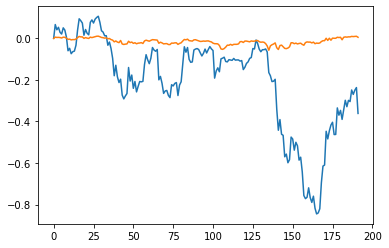

In [27]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum())
plt.plot(np.array(result_hrp_vis).cumsum())
plt.show()

In [28]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('HRP', print_stats(result_hrp_vis, result_equal_vis))

EQUAL [-0.0019, 0.0462, -0.6488, 0.0, 1.0]
HRP [0.0, 0.0061, 0.0772, 0.0002, 0.0856]


# Visualization

In [29]:
import matplotlib
current_cmap = matplotlib.cm.get_cmap()

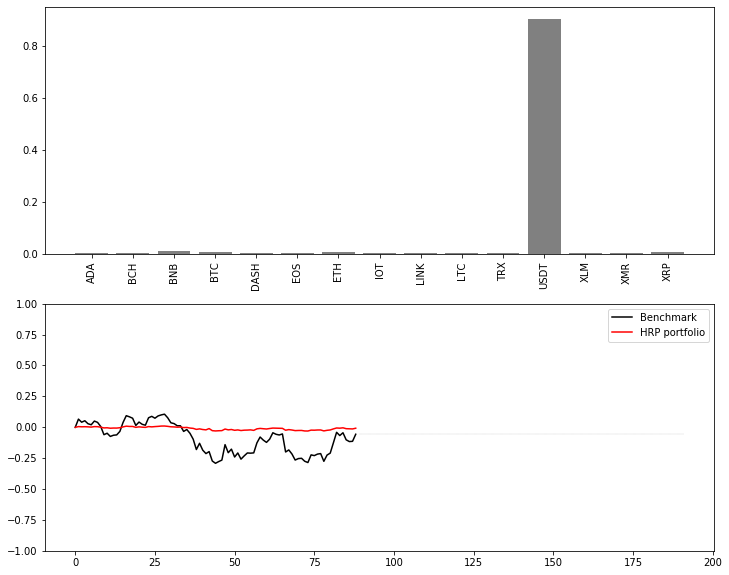

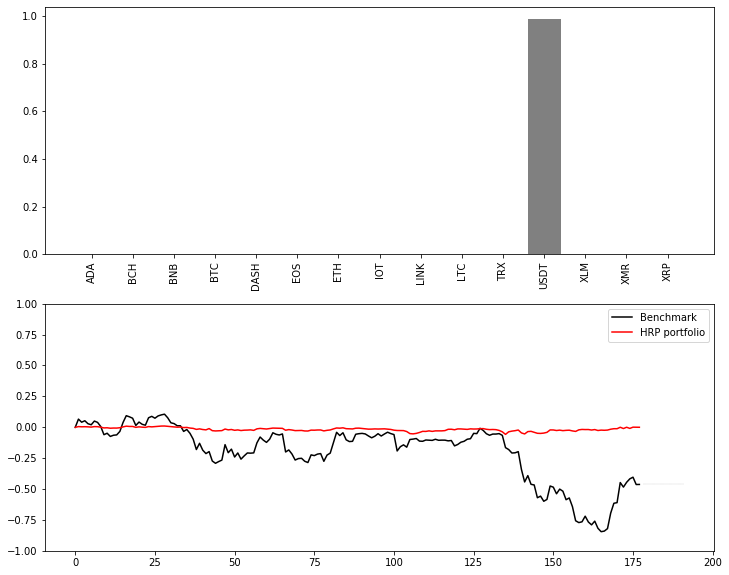

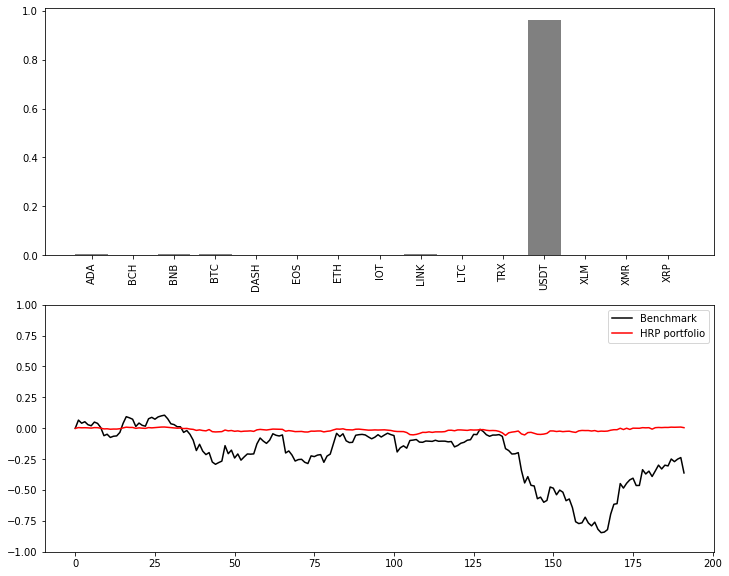

In [30]:
plot_results(result_equal, 
             result_hrp, 
             actions_hrp, 
             N_ASSETS,
             state.columns, 
             'HRP portfolio', './images/hrp/', 'series')

# Reweighting process: Forecasting 

In [31]:
from agent import SmoothingAgent

In [32]:
agent_smooth = SmoothingAgent(N_ASSETS, allow_short=True, forecast_horizon = WINDOW_HOLD)

In [33]:
actions_equal, actions_smooth = [], []
result_equal, result_smooth = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False, is_raw_time_series=True)
    
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_smooth = agent_smooth.act(state)

    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_smooth)
    result_smooth.append(r.tolist())
    actions_smooth.append(action_smooth)

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/sit

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored

In [34]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_smooth_vis = [item for sublist in result_smooth for item in sublist]

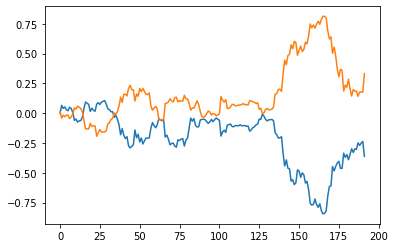

In [35]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum())
plt.plot(np.array(result_smooth_vis).cumsum())
plt.show()

In [36]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('SMOOTHING', print_stats(result_smooth_vis, result_equal_vis))

EQUAL [-0.0019, 0.0462, -0.6488, 0.0, 1.0]
SMOOTHING [0.0017, 0.0475, 0.5606, -0.0001, -0.9666]


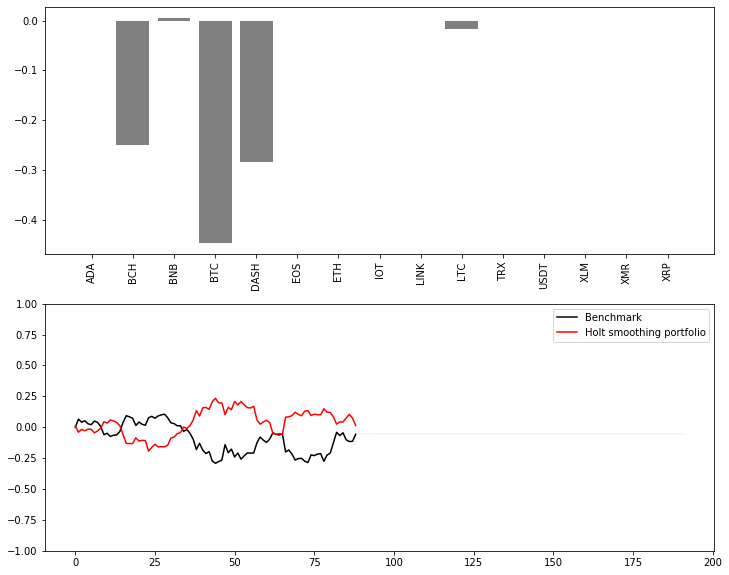

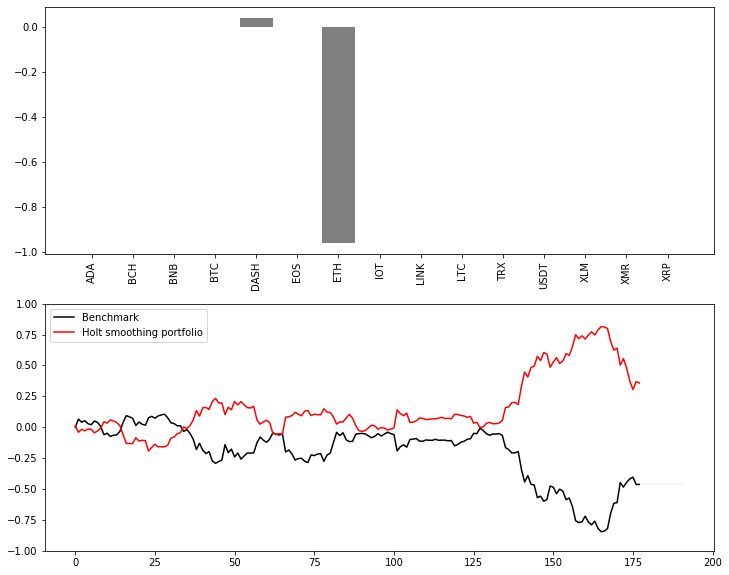

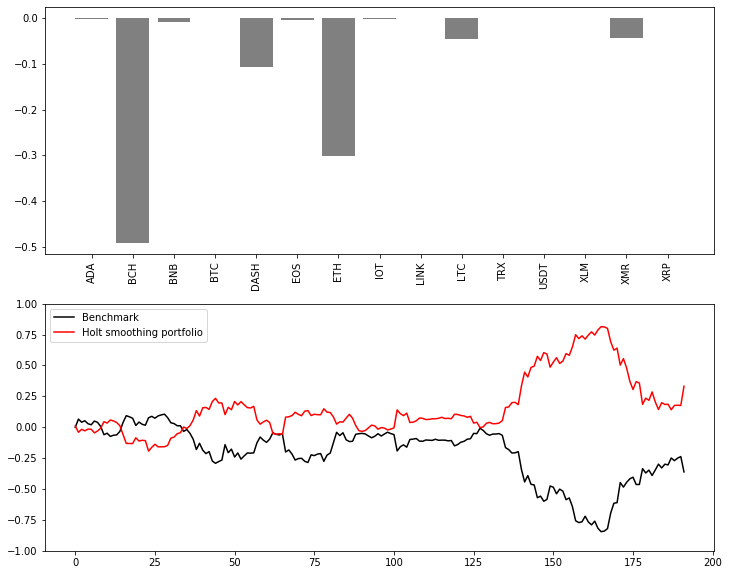

In [37]:
plot_results(result_equal, 
             result_smooth, 
             actions_smooth,
             N_ASSETS,
             state.columns, 
             'Holt smoothing portfolio', './images/smoothing/', 'series')

# Reweighting process: Autoencoder

In [38]:
from agent import AutoencoderAgent

In [39]:
agent_ae = AutoencoderAgent(N_ASSETS, allow_short=True, encoding_dim = 5)

In [40]:
actions_equal, actions_ae = [], []
result_equal, result_ae = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False, is_raw_time_series=True)
    
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_ae = agent_ae.act(state)

    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_ae)
    result_ae.append(r.tolist())
    actions_ae.append(action_ae)

In [41]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_ae_vis = [item for sublist in result_ae for item in sublist]

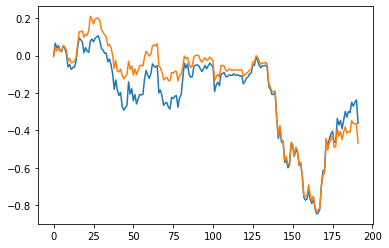

In [42]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum())
plt.plot(np.array(result_ae_vis).cumsum())
plt.show()

In [43]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('AUTOENCODER', print_stats(result_ae_vis, result_equal_vis))

EQUAL [-0.0019, 0.0462, -0.6488, 0.0, 1.0]
AUTOENCODER [-0.0024, 0.0413, -0.9266, -0.0008, 0.864]


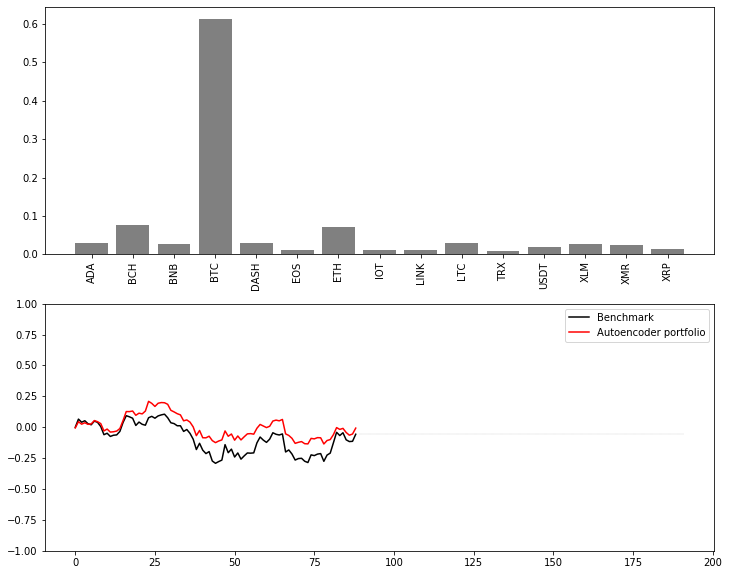

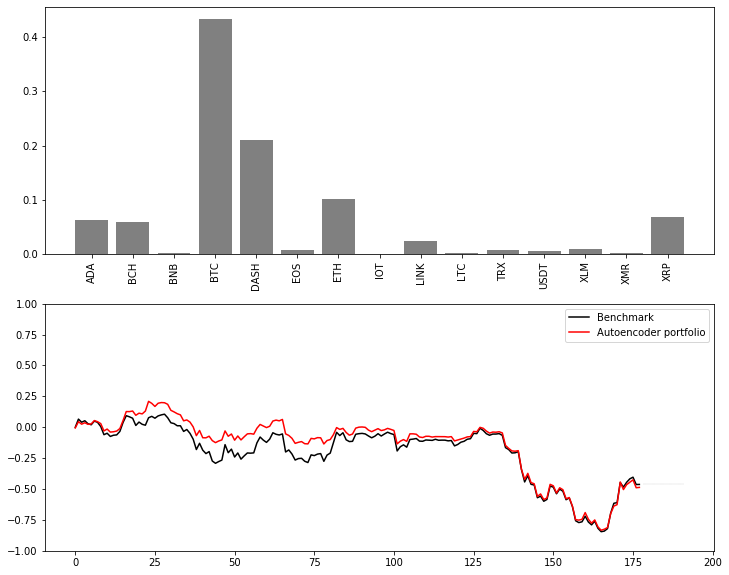

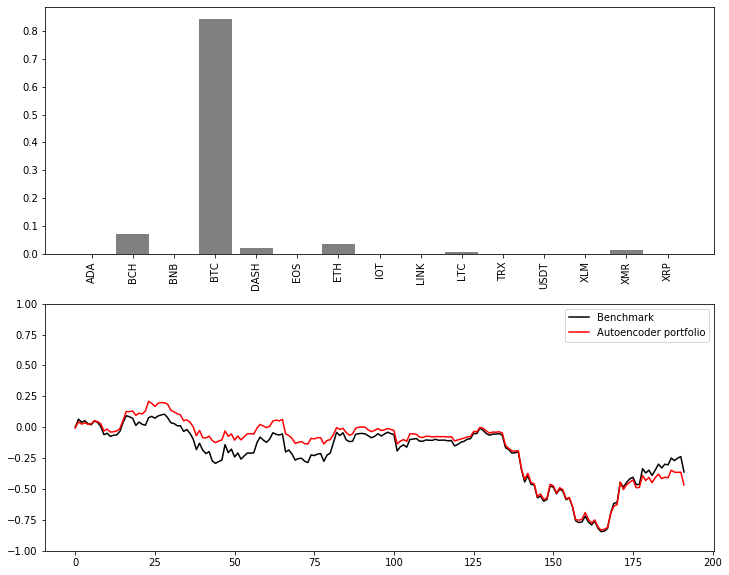

In [44]:
plot_results(result_equal, 
             result_ae, 
             actions_ae, 
             N_ASSETS,
             state.columns, 
             'Autoencoder portfolio', './images/ae/', 'series')

# Making GIFs

In [45]:
import imageio
import glob

In [46]:
name = 'decorr'

In [47]:
filenames = sorted(glob.glob('./images/' + name + '/series*.jpg'))

In [48]:
filenames

['./images/decorr/series0.jpg',
 './images/decorr/series1.jpg',
 './images/decorr/series2.jpg']

In [49]:
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./images/' + name + '_gif.gif', images, duration=0.5)